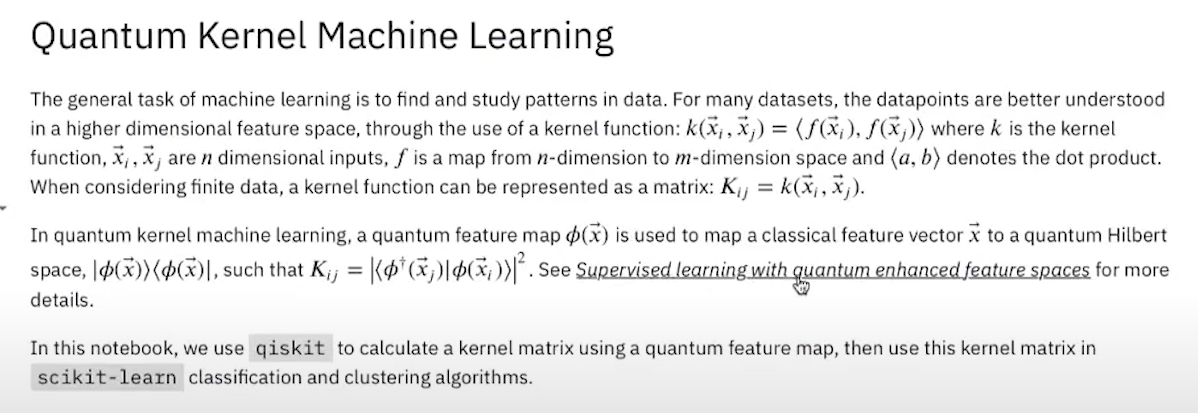

[Supervised learning with quantum-enhanced feature spaces](https://ar5iv.labs.arxiv.org/html/1804.11326)

## Classification

For our classification example, we will use the ad hoc dataset as described in [Supervised learning with quantum-enhanced feature spaces](https://ar5iv.labs.arxiv.org/html/1804.11326)
and the **scikit-learn** support vector machine classification svc algorithm.

## Classical Kernel Types

In classical machine learning, various kernel functions are commonly used for different tasks. Here are some popular kernel types:

- **Linear Kernel:** The linear kernel is the simplest and computes the dot product of the input features.

- **Radial Basis Function (RBF) Kernel:** Also known as the Gaussian kernel, it measures the similarity between data points in a high-dimensional space.

- **Polynomial Kernel:** Used to handle non-linear data by computing the polynomial expansion of the input features.

- **Sigmoid Kernel:** Similar to the hyperbolic tangent function, it is often used in neural networks.

- **Custom Kernels:** Kernels can also be tailored for specific applications, incorporating domain knowledge.

These kernels play a crucial role in Support Vector Machines (SVMs) and other kernelized machine learning algorithms, allowing them to handle complex relationships in the data.

**RBF Kernel is most famous as it gives best classification in higher dimension. RBF is more like as Gaussian Function**


## Quantum Kernel Advantage

- If we could find a kernel function which can't be easily simulated in classical need lots of resources like time space which could show us better result in feature space then we will surely get quantum advantage
 - Other area is using classical kernel like RBF data are not well separated in high dimension this can happen in extreme classification like in large no of classes and we have very less no of data point. Those kind of problem where classical solution is stuck in some 60% to 70% accuracy we can get benefited using Quantum Kernel

In [1]:
import warnings

# Suppress warning
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

from time import time

seed=12345
algorithm_globals.random_seed = seed  # a "seed" is a starting point for generating random numbers. 

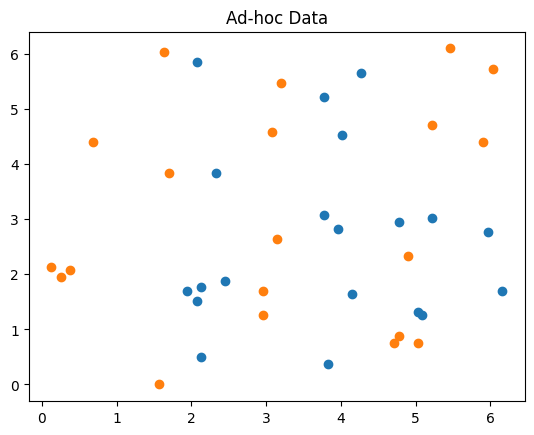

In [3]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True
)



Text(0.5, 1.0, 'Ad hoc dataset for classification')

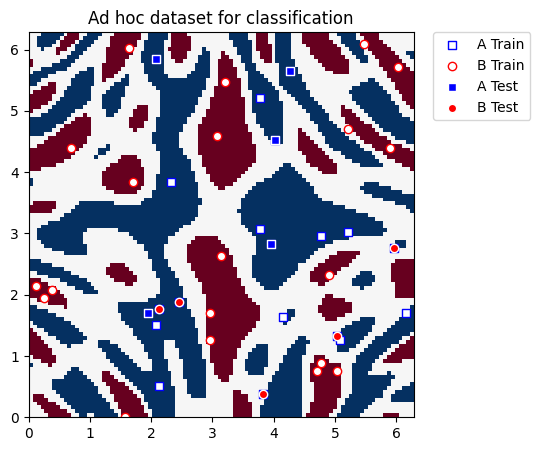

In [4]:
plt.figure(figsize=(5,5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2* np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker='s',
    facecolors='w',
    edgecolors='b',
    label="A Train",
)
    
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker='o',
    facecolors='w',
    edgecolors='r',
    label="B Train",
)

plt.scatter(
    train_features[np.where(test_labels[:] == 0), 0],
    train_features[np.where(test_labels[:] == 0), 1],
    marker='s',
    facecolors='b',
    edgecolors='w',
    label="A Test",
)

plt.scatter(
    train_features[np.where(test_labels[:] == 1), 0],
    train_features[np.where(test_labels[:] == 1), 1],
    marker='o',
    facecolors='r',
    edgecolors='w',
    label="B Test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

With our training and testing datasets ready, we set up the **QuantumKernelclass** to calculate a kernel matrix
using the **ZZFeatureMap**, and the **BasicAer** **qasm_simulator** using 1024 shots. In classical we could have used RBF or Gaussian but here using Quantum Feature Map

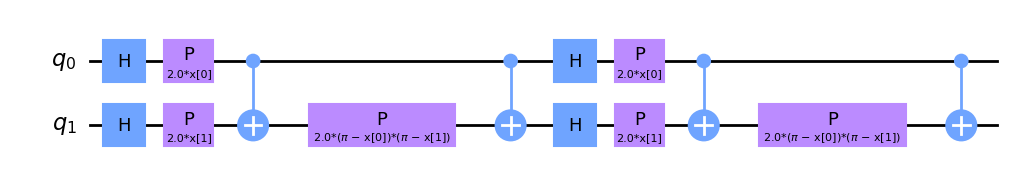

In [5]:
adhoc_feature = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement ="linear")
adhoc_feature.decompose().draw()

#### Now as we have feature map it's time to computer kernel matrix that is similarity matrix

In [6]:
adhoc_backend = QuantumInstance( 
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature, quantum_instance=adhoc_backend)

The **scikit-learn** **svc** algorithm allows us to define a custom kernel in two ways
- By providing the kernel as a callable function or by precomputing the kernel matrix. (We can compute kernel in quantum machine and use this pre compute kernel in classical algortihm)
- We can do either of these using the **QuantumKernel** class in **qiskit** (Qiskit provides a QuantumKernel class that allows you to define and compute quantum kernel directly within qiskit the Qiskit framework.)

The following code gives the kernel as a callable function:

In [7]:
print(train_features.shape)
print(test_labels.shape)

(40, 2)
(10,)


 We are using classical SVC but only passing the Quantum Kernel
 
 ### First Approach passing Quantum Kernel to Classical SVC

In [8]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

start_time = time()
adhoc_svc.fit(train_features, train_labels)

end_time = time()
duration = end_time - start_time

adhoc_score = adhoc_svc.score(test_features, test_labels)


print(f"Callable kernel classification test score: {adhoc_score}")
print("Training duration: ",duration)

Callable kernel classification test score: 1.0
Training duration:  7.5093302726745605


### Plotting Confusion Matrix 

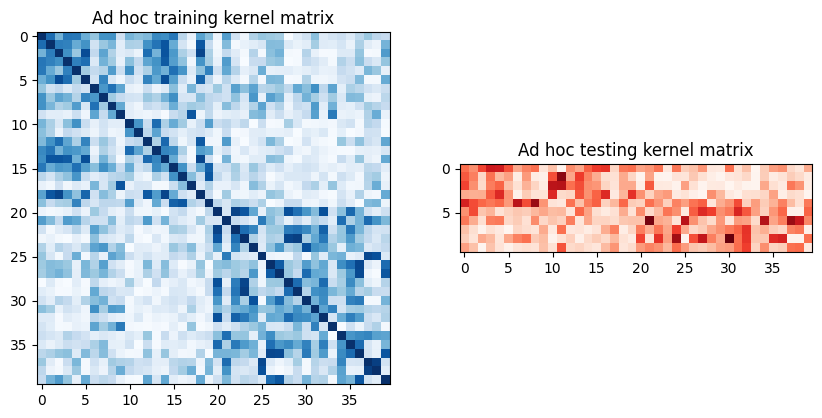

In [9]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs =plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)

axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()


In [10]:
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score}")

Precomputed kernel classification test score: 1.0


In the confusion matrix plot the more dark color means our model is able to classify it correctly as we can see
the diagonal entries are more dark means true positive and true negative are classified correctly 

### Second Approach passing Quantum Kernel to Quantum SVC (qiskit's function)

Optimization is happeining not in real quantum device but happeining via qiskit. qiskit has it's set of compiler or optimizer which can run in co-located classical resource. Like Quantum hardware on cloud is running the matrix and laptop is running optimizer cycle.

qiskit contains the qsvc class that extends the sklearn svc class that can be used as follows:

In [12]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC Classification Test Score: {qsvc_score}")

QSVC Classification Test Score: 1.0


There are many way we can improve the accuray 
- We can increase the circuit depth by increasing the reps
- We can use different entanglement technique like circular full etc thought training time will be more but may increase accuracy
- We can use error metigation technique can use **metiq** from qiskit library 